In [448]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import matplotlib.pyplot as plt
import numpy as np

In [449]:
n_features = 300
X, y = make_classification(n_samples = 8000, n_features = n_features, n_informative = 30, random_state=5)
X_train, X_test = np.split(X, [1000])
y_train, y_test = np.split(y, [1000])

# Random Selection

In [450]:
import random
def randomSelection(CVal):
    random_scores_train = {}
    random_scores_test = {}
    random_selection = random.sample(range(0, n_features), n_features)
    for i in range(1, n_features, 2):
        features = random_selection[:i]
    
        svm = LinearSVC(C=CVal, max_iter=50000, dual=False)
        svm.fit(X_train[:,features], y_train)

        random_scores_train[i] = svm.score(X_train[:,features], y_train)
        random_scores_test[i] = svm.score(X_test[:,features], y_test)
    return random_scores_train, random_scores_test

rscore = {}
for k in range(10):
    rscore[k] = {}
    for i in [1, 10, 100]:
        #with time_code('TEST C#' + str(i)):
        rscore[k][i] = randomSelection(i)

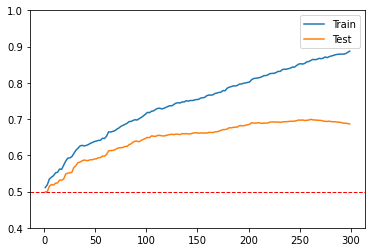

In [451]:
tscore = {}
for c in [10]:
    tscore[c] = ({}, {})
    for x in rscore[0][c][0].keys():
        yT = np.mean([rscore[k][c][0][x] for k in range(10)])
        yt = np.mean([rscore[k][c][1][x] for k in range(10)])
        tscore[c][0][x] = yT
        tscore[c][1][x] = yt

xscore = tscore[10]
plt.plot(xscore[0].keys(), xscore[0].values(), label = "Train")
plt.plot(xscore[1].keys(), xscore[1].values(), label = "Test")
plt.legend()
plt.ylim([0.4,1.0])
plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")
plt.show()

# SVM-RFE

In [461]:
class SVM_RFE():
    def __init__(self, n_features_to_select, step=4):
        self.n_features_to_select = n_features_to_select
        self.step = step

    def fit(self, X0, y):
        self.scores_ = {}
        self.points_ = []
        
        n_features_to_select = self.n_features_to_select
        n_features = X0.shape[1]
        if n_features_to_select is None:
            n_features_to_select = n_features
            
        support_ = np.ones(n_features, dtype=bool)
        ranking_ = np.ones(n_features, dtype=int)
    
        # np.sum(support_) is the number of selected features.
        # It starts at n_features and decreases every iteration.
        while np.sum(support_) > n_features_to_select:
            
            # Remaining features, represented with a list of indices.
            features = np.arange(n_features)[support_]
            X = X0[:, features]
            self.points_ = [np.sum(support_) - 1] + self.points_

            # Declare and train the SVM
            #with time_code('SVM #' + str(np.sum(support_))):
            estimator = LinearSVC(C=10, max_iter=50000, dual=False)
            estimator.fit(X, y)

            # Get importance and rank them
            importances = estimator.coef_ ** 2
            ranks = np.argsort(importances)

            # Flatten ranks, required for Multi-Class Classification.
            ranks = np.ravel(ranks)

            # Calculate t (step)
            threshold = min(self.step, np.sum(support_) - n_features_to_select)

            # Eliminate the worse feature
            for i in range(0, threshold):
                selected_feature = features[ranks[i]]
                support_[selected_feature] = False
                ranking_[np.logical_not(support_)] += 1

            # Record score
            self.scores_[np.sum(support_)] = estimator.score(X,y)


        # Set final attributes
        self.n_features_ = support_.sum()
        self.support_ = support_
        self.ranking_ = ranking_

        return self


In [462]:
def trainf(XT, yT, step):
    rfe = SVM_RFE(n_features_to_select=1, step=step)
    rfe.fit(X_train, y_train)
    return rfe

def TEST_SVM_RFE(XT, yT, Xt, yt, step):
    rfe = trainf(XT, yT, step)

    train_scores = {}
    test_scores = {}
    test_selection = np.argsort(rfe.ranking_)

    for i in range(1, n_features, 1):
        features = test_selection[:i]

        svm = LinearSVC(C=10, max_iter=50000, dual=False)
        svm.fit(XT[:,features], yT)

        train_scores[i] = svm.score(XT[:,features], yT)
        test_scores[i] = svm.score(Xt[:,features], yt)

    return train_scores, test_scores, rfe.points_

def plot_train_vs_test(train_scores, test_scores, points = []):
    if points != []: plt.scatter(points, [train_scores[x] for x in points], marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")
    plt.show()

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

@time_func
def SVM_RFE_NO_STEP():
    kf = KFold(n_splits=32, shuffle=True)
    points = []
    train = {}
    test = {}
    
    k = 0
    for train_index, test_index in kf.split(X_train):
        XT, Xt = X_train[train_index], X_train[test_index]
        yT, yt = y_train[train_index], y_train[test_index]
        ktrain, ktest, points = TEST_SVM_RFE(XT, yT, Xt, yt, 1)
        train[k] = ktrain
        test[k] = ktest
        k += 1
 
    train_scores = mean_of_arrays(train)
    test_scores = mean_of_arrays(test)
    plot_train_vs_test(train_scores, test_scores)
    print("AT 15", train_scores[15], test_scores[15], "WITH", len(points), "ITERATIONS")

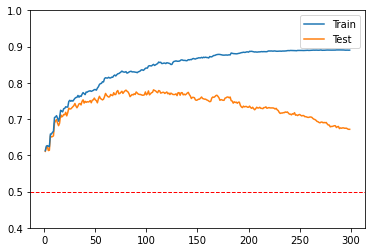

AT 15 0.7048061177494052 0.6887285786290323 WITH 299 ITERATIONS


In [454]:
SVM_RFE_NO_STEP()

# SVM-RFE with Step


In [463]:
@time_func
def SVM_RFE_W_STEP(step):
    kf = KFold(n_splits=32, shuffle=True)
    points = []
    train = {}
    test = {}
    
    k = 0
    for train_index, test_index in kf.split(X_train):
        XT, Xt = X_train[train_index], X_train[test_index]
        yT, yt = y_train[train_index], y_train[test_index]
        ktrain, ktest, points = TEST_SVM_RFE(XT, yT, Xt, yt, step)
        train[k] = ktrain
        test[k] = ktest
        k += 1
 
    train_scores = mean_of_arrays(train)
    test_scores = mean_of_arrays(test)
    plot_train_vs_test(train_scores, test_scores, points)
    print("AT 15", train_scores[15], test_scores[15], "WITH", len(points), "ITERATIONS")

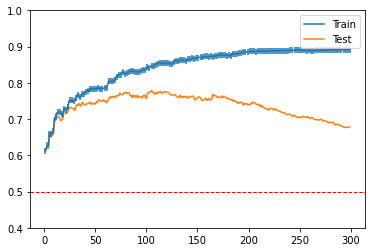

AT 15 0.7204837901069518 0.703188004032258 WITH 150 ITERATIONS


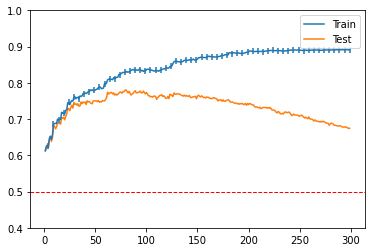

AT 15 0.6993551784023744 0.6890120967741935 WITH 60 ITERATIONS


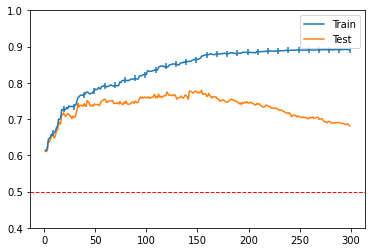

AT 15 0.6997094924583578 0.6870274697580645 WITH 30 ITERATIONS


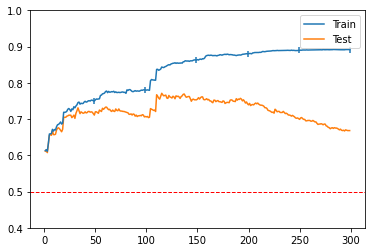

AT 15 0.688161252974439 0.672883064516129 WITH 6 ITERATIONS


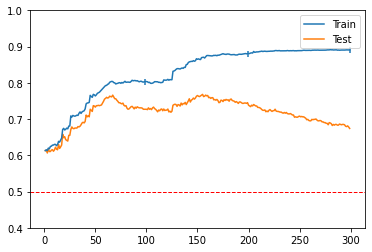

AT 15 0.6363230909751896 0.619140625 WITH 3 ITERATIONS


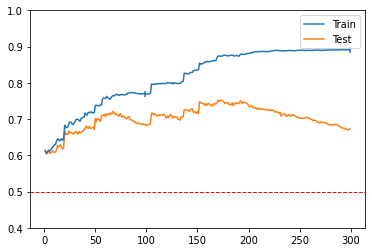

AT 15 0.6395482317546418 0.6258190524193548 WITH 2 ITERATIONS


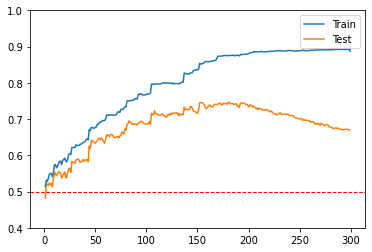

AT 15 0.5836766198432396 0.551852318548387 WITH 1 ITERATIONS


In [457]:
SVM_RFE_W_STEP(2)
SVM_RFE_W_STEP(5)
SVM_RFE_W_STEP(10)
SVM_RFE_W_STEP(50)
SVM_RFE_W_STEP(100)
SVM_RFE_W_STEP(200)
SVM_RFE_W_STEP(300)

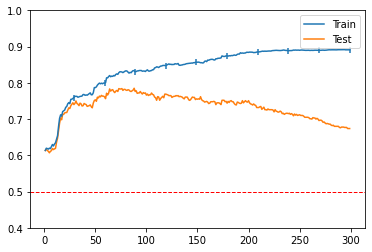

AT 15 0.7021933889095003 0.6889175907258064 WITH 10 ITERATIONS


In [464]:
SVM_RFE_W_STEP(30)

# SVM-RFE with DynamicStep

In [465]:
class SVM_RFE():
    def __init__(self, n_features_to_select, percentage=0.3):
        self.n_features_to_select = n_features_to_select
        self.percentage = percentage

    def fit(self, X0, y):
        self.scores_ = {}
        self.points_ = []

        n_features_to_select = self.n_features_to_select
        n_features = X0.shape[1]
        if n_features_to_select is None:
            n_features_to_select = n_features
            
        support_ = np.ones(n_features, dtype=bool)
        ranking_ = np.ones(n_features, dtype=int)
    
        # np.sum(support_) is the number of selected features.
        # It starts at n_features and decreases every iteration.
        while np.sum(support_) > n_features_to_select:
            
            # Remaining features, represented with a list of indices.
            features = np.arange(n_features)[support_]
            X = X0[:, features]
            self.points_ = [np.sum(support_) - 1] + self.points_

            # Declare and train the SVM
            estimator = LinearSVC(C=10, max_iter=2000, dual=False)
            estimator.fit(X, y)

            # Get importance and rank them
            importances = estimator.coef_ ** 2
            ranks = np.argsort(importances)

            # Flatten ranks, required for Multi-Class Classification.
            ranks = np.ravel(ranks)

            # Calculate t (step)
            min_threshold = np.sum(support_) - n_features_to_select
            threshold = max(int(self.percentage * min_threshold), 1)

            # Eliminate the worse feature
            for i in range(0, threshold):
                selected_feature = features[ranks[i]]
                support_[selected_feature] = False
                ranking_[np.logical_not(support_)] += 1

            # Record score
            self.scores_[np.sum(support_)] = estimator.score(X,y)


        # Set final attributes
        self.n_features_ = support_.sum()
        self.support_ = support_
        self.ranking_ = ranking_

        return self

In [466]:
def trainf(XT, yT, percentage):
    rfe = SVM_RFE(n_features_to_select=15, percentage=percentage)
    rfe.fit(X_train, y_train)
    return rfe

@time_func
def SVM_RFE_W_DSTEP(percentage):
    kf = KFold(n_splits=32, shuffle=True)
    points = []
    train = {}
    test = {}
    
    k = 0
    for train_index, test_index in kf.split(X_train):
        XT, Xt = X_train[train_index], X_train[test_index]
        yT, yt = y_train[train_index], y_train[test_index]
        ktrain, ktest, points = TEST_SVM_RFE(XT, yT, Xt, yt, percentage)
        train[k] = ktrain
        test[k] = ktest
        k += 1
 
    train_scores = mean_of_arrays(train)
    test_scores = mean_of_arrays(test)
    plot_train_vs_test(train_scores, test_scores, points)
    print("AT 15", train_scores[15], test_scores[15], "WITH", len(points), "ITERATIONS")

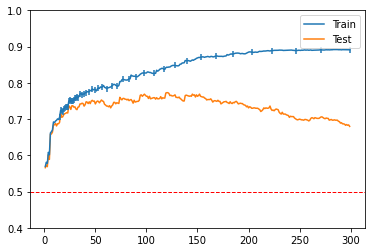

AT 15 0.7052581138751717 0.6911227318548387 WITH 47 ITERATIONS


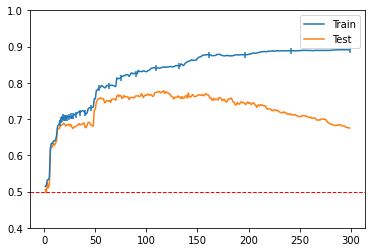

AT 15 0.6902253364101186 0.6749621975806451 WITH 25 ITERATIONS


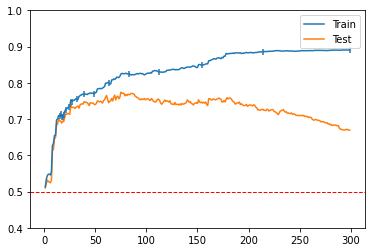

AT 15 0.7077421769055598 0.6949974798387096 WITH 17 ITERATIONS


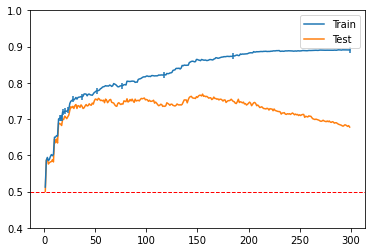

AT 15 0.7021293558473847 0.6872794858870968 WITH 13 ITERATIONS


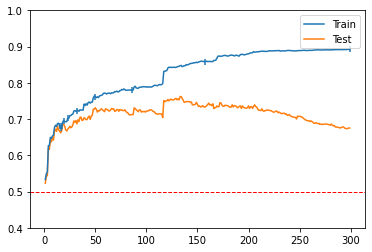

AT 15 0.681484090482648 0.667086693548387 WITH 10 ITERATIONS


In [460]:
SVM_RFE_W_DSTEP(0.1)
SVM_RFE_W_DSTEP(0.2)
SVM_RFE_W_DSTEP(0.3)
SVM_RFE_W_DSTEP(0.4)
SVM_RFE_W_DSTEP(0.5)